# Results Analysis - Use Old Summary Statistics and Similarity Measure 

In [1]:
import os
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../')

In [2]:
from scipy.signal import argrelmin, argrelmax

In [3]:
from dap import DAPcython
from dap.utils import obs_params, load_current
from tqdm import tqdm
from scipy.spatial import distance

### Set Parameters

In [4]:
dt = 1e-2
params, labels = obs_params(reduced_model=False)
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

### load the file

In [5]:
# directory = './parameters/'
# dir = glob.glob(directory + '*')

# fname_start = dir[0].find('dap_')
# fname_stop = dir[0].find('n_')
# fname = dir[0][fname_start:fname_stop] + '.csv'

# df_param = pd.read_csv(fname)

In [6]:
df_param = pd.read_csv('dap_models_4_param_1x20.csv')

### calculate DAP

In [7]:
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

# define a model
dap = DAPcython(-75, params)

In [8]:
# run models on original parameters
U_step = dap.simulate(dts, ts, Is)
U_ramp = dap.simulate(dtr, tr, Ir)

### calculate the similarities

In [9]:
d_step = distance.euclidean(vs, U_step)
d_step

2650.3042379402655

In [10]:
d_ramp = distance.euclidean(vr, U_ramp)
d_ramp

489.85195375666297

In [11]:
d_step+d_ramp

3140.1561916969285

### run for all cells and save into the the DF

In [12]:
df_paramT = df_param.transpose()
df_paramT.head()

,0,1,2,3
Unnamed: 0,gbar_nap,gbar_leak,gbar_nat,gbar_kdr
1x14,17.1737,1.07467,131.423,3.41051
1x35,17.0972,1.03987,117.684,3.73748
1x9,19.0074,0.991425,95.3657,2.97607
1x19,16.3705,1.0285,141.775,3.43003


In [13]:
df_paramT.drop('Unnamed: 0', inplace=True)
df_paramT.head()

,0,1,2,3
1x14,17.1737,1.07467,131.423,3.41051
1x35,17.0972,1.03987,117.684,3.73748
1x9,19.0074,0.991425,95.3657,2.97607
1x19,16.3705,1.0285,141.775,3.43003
1x24,15.1533,1.10018,163.721,3.05554


In [14]:
daps = []
U_steps = []
U_ramps = []

for i, j in tqdm(df_paramT.iterrows()):
    # get parameters
    par_temp = j.values

    # define a model
    daps.append(DAPcython(-75, j))

    # run model
    U_steps.append(dap.simulate(dts, ts, Is))
    U_ramps.append(dap.simulate(dtr, tr, Ir))

34it [01:09,  2.03s/it]


## Calculating the features for each parameter

In [15]:
def calc_ramp_sum_stats(v, t, dt, t_on, t_off):
    """Calculate summary statistics of a single run with ramp current(single spike with DAP)"""
    stats = []
    stats_idx = []
#     v = v.transpose()
    N = v.shape[0]

    # resting potential
    rest_pot = np.mean(v[t<t_on])
    rest_pot_std = np.std(v[int(.9*t_on/dt):int(t_on/dt)])   # TODO: add if needed

    # RMSE
#     n = len(self.v0)
#     rmse = np.linalg.norm(v - self.v0) / np.sqrt(n)

    # more then one AP:
    multiple_AP = np.shape(np.where(v > 0))[1]

    #case without any action potential or more then one AP
    if (np.all(v <= 20)):
        AP_onsets = 999
        AP_amp = 999
        AP_width = 999
        DAP_amp = 999
        DAP_width = 999
        DAP_deflection = 999
        DAP_time = 999
        mAHP = 999
        fAHP = 999

    else:
        threshold = -30
        # hyperpolarization after DAP
        mAHP_idx = np.argmin(v)
        mAHP = v[mAHP_idx]

        # Action potential
        AP_onsets = np.where(v > threshold)[0]
        AP_start = AP_onsets[0]
        AP_end = AP_onsets[-1]
        AP_max_idx = AP_start + np.argmax(v[AP_start:AP_end])
        AP_max = v[AP_max_idx]
        AP_amp = AP_max - rest_pot

        # AP width
        AP_onsets_half_max = np.where(v > (AP_max+rest_pot)/2)[0]
        AP_width = t[AP_onsets_half_max[-1]] - t[AP_onsets_half_max[0]]

        # DAP: fAHP
        v_dap = v[AP_max_idx:]

        fAHP_idx = argrelmin(v[AP_max_idx:])[0][0] + AP_max_idx
        fAHP = v[fAHP_idx]

        # DAP amplitude
        DAP_max_idx = argrelmax(v_dap)[0][1] + AP_max_idx
        DAP_max = v[DAP_max_idx]
        DAP_amp = DAP_max - rest_pot

        DAP_deflection = DAP_amp - (fAHP - rest_pot)
        DAP_time = t[DAP_max_idx] - t[AP_max_idx]    # Time between AP and DAP maximum

        # Width of DAP: between fAHP and halfsize of fAHP after DAP max
        vnorm = v[DAP_max_idx:] - rest_pot

        if np.any((abs(vnorm) < abs(fAHP - rest_pot)/2)):
            half_max = np.where((abs(vnorm) < abs(fAHP - rest_pot)/2))[0]

            DAP_width_idx = DAP_max_idx + half_max[0]
            DAP_width = (DAP_width_idx - fAHP_idx) * dt
        else:
            DAP_width = 999


    sum_stats_vec = np.array([
                    rest_pot,
                    AP_amp,
                    AP_width,
                    fAHP,
                    DAP_amp,
                    DAP_width,
                    DAP_deflection,
                    DAP_time,
                    mAHP,
                    ])


    return sum_stats_vec

In [16]:
sim = calc_ramp_sum_stats(U_ramps[0], tr, dtr, t_onr, t_offr)
pd.DataFrame(data=sim)

,0
0,-75.1333
1,[131.0904952028053]
2,0.75
3,[-64.53629526688441]
4,[10.550658548274896]
5,22.92
6,[-0.046336143448968414]
7,2.4
8,[-77.72183321671001]


## Features Step Current: Outside of The Function
to pick required parameters

In [17]:
t, dt, t_on, t_off = ts, dts, t_ons, t_offs
v = U_steps[0].copy()

stats = []

N = v.shape[0]
N

23000

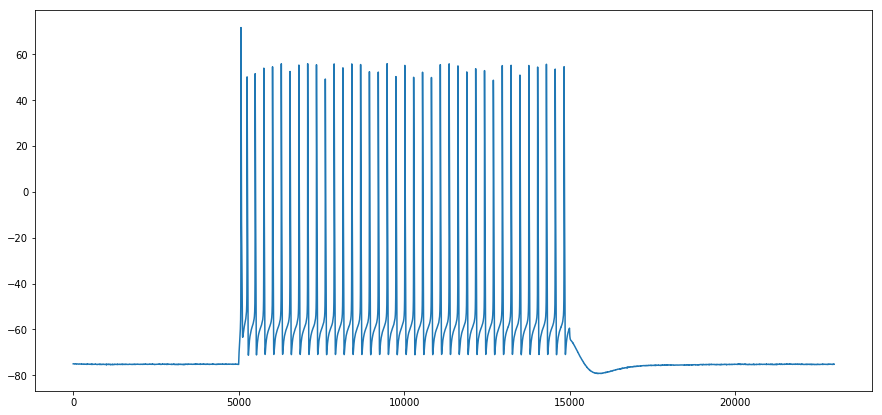

In [18]:
plt.figure(figsize=(15,7))
plt.plot(U_steps[0]);

### Get The spike indicies and times

In [19]:
# put everything to -10 that is below -10 or has negative slope
ind = np.where(v < -10)
v[ind] = -10
ind = np.where(np.diff(v) < 0)
v[ind] = -10

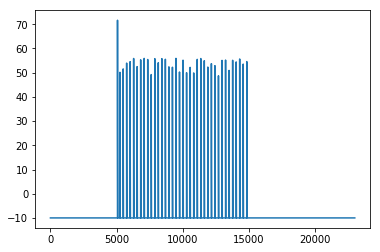

In [20]:
plt.plot(v);

In [21]:
v = v.transpose()

In [22]:
np.diff(v)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [23]:
# remaining negative slopes are at spike peaks
ind = np.where(np.diff(v) > 0)
ind = ind[1]

In [24]:
# choose one spike time within close spike times
ind1 = np.array(ind)
ind1

array([ 5068,  5069,  5071,  5252,  5253,  5254,  5496,  5497,  5498,
        5758,  5759,  6022,  6023,  6025,  6287,  6288,  6290,  6550,
        6551,  6552,  6818,  6819,  6821,  7084,  7085,  7087,  7349,
        7350,  7351,  7616,  7617,  7618,  7884,  7885,  7887,  8148,
        8149,  8150,  8417,  8418,  8420,  8683,  8684,  8685,  8949,
        8950,  8951,  9218,  9219,  9484,  9485,  9486,  9488,  9751,
        9752,  9753, 10020, 10021, 10023, 10286, 10287, 10288, 10556,
       10557, 10824, 10825, 10826, 11093, 11094, 11096, 11359, 11360,
       11361, 11363, 11625, 11626, 11627, 11893, 11894, 12161, 12162,
       12163, 12429, 12430, 12696, 12697, 12965, 12966, 12967, 13233,
       13234, 13236, 13499, 13500, 13501, 13768, 13769, 13771, 14035,
       14036, 14038, 14300, 14301, 14303, 14565, 14566, 14567, 14834,
       14835, 14837])

In [25]:
spike_times = np.array(t)[ind]
spike_times

array([253.4 , 253.45, 253.55, 262.6 , 262.65, 262.7 , 274.8 , 274.85,
       274.9 , 287.9 , 287.95, 301.1 , 301.15, 301.25, 314.35, 314.4 ,
       314.5 , 327.5 , 327.55, 327.6 , 340.9 , 340.95, 341.05, 354.2 ,
       354.25, 354.35, 367.45, 367.5 , 367.55, 380.8 , 380.85, 380.9 ,
       394.2 , 394.25, 394.35, 407.4 , 407.45, 407.5 , 420.85, 420.9 ,
       421.  , 434.15, 434.2 , 434.25, 447.45, 447.5 , 447.55, 460.9 ,
       460.95, 474.2 , 474.25, 474.3 , 474.4 , 487.55, 487.6 , 487.65,
       501.  , 501.05, 501.15, 514.3 , 514.35, 514.4 , 527.8 , 527.85,
       541.2 , 541.25, 541.3 , 554.65, 554.7 , 554.8 , 567.95, 568.  ,
       568.05, 568.15, 581.25, 581.3 , 581.35, 594.65, 594.7 , 608.05,
       608.1 , 608.15, 621.45, 621.5 , 634.8 , 634.85, 648.25, 648.3 ,
       648.35, 661.65, 661.7 , 661.8 , 674.95, 675.  , 675.05, 688.4 ,
       688.45, 688.55, 701.75, 701.8 , 701.9 , 715.  , 715.05, 715.15,
       728.25, 728.3 , 728.35, 741.7 , 741.75, 741.85])

In [26]:
spike_times_stim = spike_times[(spike_times > t_on) & (spike_times < t_off)]
spike_times_stim

array([253.4 , 253.45, 253.55, 262.6 , 262.65, 262.7 , 274.8 , 274.85,
       274.9 , 287.9 , 287.95, 301.1 , 301.15, 301.25, 314.35, 314.4 ,
       314.5 , 327.5 , 327.55, 327.6 , 340.9 , 340.95, 341.05, 354.2 ,
       354.25, 354.35, 367.45, 367.5 , 367.55, 380.8 , 380.85, 380.9 ,
       394.2 , 394.25, 394.35, 407.4 , 407.45, 407.5 , 420.85, 420.9 ,
       421.  , 434.15, 434.2 , 434.25, 447.45, 447.5 , 447.55, 460.9 ,
       460.95, 474.2 , 474.25, 474.3 , 474.4 , 487.55, 487.6 , 487.65,
       501.  , 501.05, 501.15, 514.3 , 514.35, 514.4 , 527.8 , 527.85,
       541.2 , 541.25, 541.3 , 554.65, 554.7 , 554.8 , 567.95, 568.  ,
       568.05, 568.15, 581.25, 581.3 , 581.35, 594.65, 594.7 , 608.05,
       608.1 , 608.15, 621.45, 621.5 , 634.8 , 634.85, 648.25, 648.3 ,
       648.35, 661.65, 661.7 , 661.8 , 674.95, 675.  , 675.05, 688.4 ,
       688.45, 688.55, 701.75, 701.8 , 701.9 , 715.  , 715.05, 715.15,
       728.25, 728.3 , 728.35, 741.7 , 741.75, 741.85])

In [27]:
ind_stim1 = ind1[(spike_times > t_on) & (spike_times < t_off)]
ind_stim1

array([ 5068,  5069,  5071,  5252,  5253,  5254,  5496,  5497,  5498,
        5758,  5759,  6022,  6023,  6025,  6287,  6288,  6290,  6550,
        6551,  6552,  6818,  6819,  6821,  7084,  7085,  7087,  7349,
        7350,  7351,  7616,  7617,  7618,  7884,  7885,  7887,  8148,
        8149,  8150,  8417,  8418,  8420,  8683,  8684,  8685,  8949,
        8950,  8951,  9218,  9219,  9484,  9485,  9486,  9488,  9751,
        9752,  9753, 10020, 10021, 10023, 10286, 10287, 10288, 10556,
       10557, 10824, 10825, 10826, 11093, 11094, 11096, 11359, 11360,
       11361, 11363, 11625, 11626, 11627, 11893, 11894, 12161, 12162,
       12163, 12429, 12430, 12696, 12697, 12965, 12966, 12967, 13233,
       13234, 13236, 13499, 13500, 13501, 13768, 13769, 13771, 14035,
       14036, 14038, 14300, 14301, 14303, 14565, 14566, 14567, 14834,
       14835, 14837])

In [28]:
# ind_stim1 = ind_stim1[np.append(1,np.diff(spike_times_stim))>0.5] # ??????????????????????
ind_stim = ind_stim1.astype(int)
ind_stim

array([ 5068,  5069,  5071,  5252,  5253,  5254,  5496,  5497,  5498,
        5758,  5759,  6022,  6023,  6025,  6287,  6288,  6290,  6550,
        6551,  6552,  6818,  6819,  6821,  7084,  7085,  7087,  7349,
        7350,  7351,  7616,  7617,  7618,  7884,  7885,  7887,  8148,
        8149,  8150,  8417,  8418,  8420,  8683,  8684,  8685,  8949,
        8950,  8951,  9218,  9219,  9484,  9485,  9486,  9488,  9751,
        9752,  9753, 10020, 10021, 10023, 10286, 10287, 10288, 10556,
       10557, 10824, 10825, 10826, 11093, 11094, 11096, 11359, 11360,
       11361, 11363, 11625, 11626, 11627, 11893, 11894, 12161, 12162,
       12163, 12429, 12430, 12696, 12697, 12965, 12966, 12967, 13233,
       13234, 13236, 13499, 13500, 13501, 13768, 13769, 13771, 14035,
       14036, 14038, 14300, 14301, 14303, 14565, 14566, 14567, 14834,
       14835, 14837])

### firing rate

In [29]:
firing_rate = 1e3*np.absolute(spike_times_stim.shape[0]/(t_off-t_on))

time_1st_spike = spike_times_stim[spike_times_stim>t_on][0]

### Average Spike Width and InterSpikeInterval

In [30]:
if spike_times_stim.shape[0] == 1:
    delta_ind_spik = np.round(t[(t>t_on) & (t<t_off)].shape[0]/2).astype(int)
else:
    ISI = np.diff(spike_times_stim).astype(float)
    delta_ind_spik = np.round(np.min(ISI)/(2*dt)).astype(int)    

In [31]:
ISI

array([ 0.05,  0.1 ,  9.05,  0.05,  0.05, 12.1 ,  0.05,  0.05, 13.  ,
        0.05, 13.15,  0.05,  0.1 , 13.1 ,  0.05,  0.1 , 13.  ,  0.05,
        0.05, 13.3 ,  0.05,  0.1 , 13.15,  0.05,  0.1 , 13.1 ,  0.05,
        0.05, 13.25,  0.05,  0.05, 13.3 ,  0.05,  0.1 , 13.05,  0.05,
        0.05, 13.35,  0.05,  0.1 , 13.15,  0.05,  0.05, 13.2 ,  0.05,
        0.05, 13.35,  0.05, 13.25,  0.05,  0.05,  0.1 , 13.15,  0.05,
        0.05, 13.35,  0.05,  0.1 , 13.15,  0.05,  0.05, 13.4 ,  0.05,
       13.35,  0.05,  0.05, 13.35,  0.05,  0.1 , 13.15,  0.05,  0.05,
        0.1 , 13.1 ,  0.05,  0.05, 13.3 ,  0.05, 13.35,  0.05,  0.05,
       13.3 ,  0.05, 13.3 ,  0.05, 13.4 ,  0.05,  0.05, 13.3 ,  0.05,
        0.1 , 13.15,  0.05,  0.05, 13.35,  0.05,  0.1 , 13.2 ,  0.05,
        0.1 , 13.1 ,  0.05,  0.1 , 13.1 ,  0.05,  0.05, 13.35,  0.05,
        0.1 ])

In [32]:
delta_ind_spik

0

In [33]:
t

array([0.00000e+00, 5.00000e-02, 1.00000e-01, ..., 1.14985e+03,
       1.14990e+03, 1.14995e+03])

In [34]:
v=v.transpose()

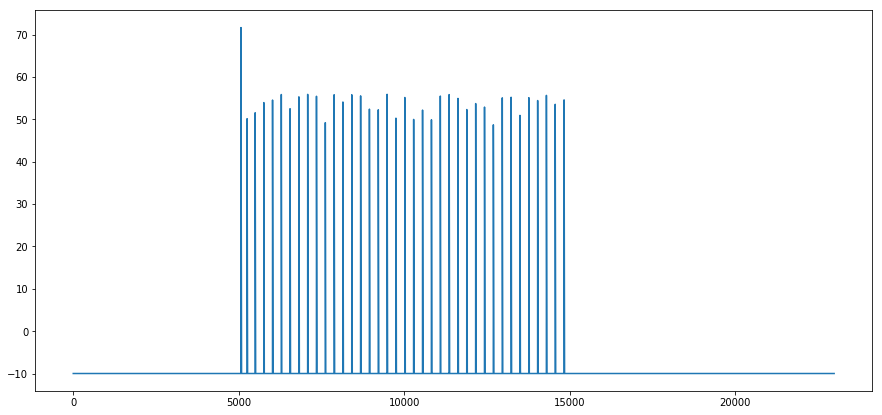

In [35]:
plt.figure(figsize=(15,7))
plt.plot(v);

In [36]:
spike_width1 = np.zeros_like(spike_times_stim)
for i_sp in range(spike_times_stim.shape[0]):
    # voltages post-spike
    x_isi = v[ind_stim[i_sp].astype(int):np.minimum(ind_stim[i_sp].astype(int)+delta_ind_spik,N)]
    t_isi = t[ind_stim[i_sp].astype(int):np.minimum(ind_stim[i_sp].astype(int)+delta_ind_spik,N)]
    
#     print(x_isi)
#     print(t_isi)
    
#     x_post = x_isi[0:np.maximum(np.argmin(x_isi),2)]
#     t_post = t_isi[0:np.maximum(np.argmin(x_isi),2)]

   
#     # half-maximum voltage
#     x_half_max = 0.5*(x_post[-1]+x_post[0])

#     # voltages pre-spike
#     x_pre = v[np.maximum(ind_stim[i_sp].astype(int)-delta_ind_spik,0):ind_stim[i_sp].astype(int)]
#     t_pre = t[np.maximum(ind_stim[i_sp].astype(int)-delta_ind_spik,0):ind_stim[i_sp].astype(int)]

#     spike_width1[i_sp] = t_post[np.argmin(np.absolute(x_post - x_half_max))]-t_pre[np.argmin(np.absolute(x_pre - x_half_max))]

# spike_width = np.mean(spike_width1)

In [38]:
# spike_width

In [39]:
t_begin = t[(t>t_on) & (t<time_1st_spike)]
v_begin = v[(t>t_on) & (t<time_1st_spike)]
t_begin

array([250.05, 250.1 , 250.15, 250.2 , 250.25, 250.3 , 250.35, 250.4 ,
       250.45, 250.5 , 250.55, 250.6 , 250.65, 250.7 , 250.75, 250.8 ,
       250.85, 250.9 , 250.95, 251.  , 251.05, 251.1 , 251.15, 251.2 ,
       251.25, 251.3 , 251.35, 251.4 , 251.45, 251.5 , 251.55, 251.6 ,
       251.65, 251.7 , 251.75, 251.8 , 251.85, 251.9 , 251.95, 252.  ,
       252.05, 252.1 , 252.15, 252.2 , 252.25, 252.3 , 252.35, 252.4 ,
       252.45, 252.5 , 252.55, 252.6 , 252.65, 252.7 , 252.75, 252.8 ,
       252.85, 252.9 , 252.95, 253.  , 253.05, 253.1 , 253.15, 253.2 ,
       253.25, 253.3 , 253.35])

In [40]:
np.diff(v_begin.transpose(), n=2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [41]:
# latency from stimulus onset to first spike and mean action potential overshoot
if t_begin.shape[0] == 0:
    AP_latency = 10000
    AP_overshoot_mn = np.max(v[(t > t_on) & (t < t_off)])
elif t_begin.shape[0] == 1 or t_begin.shape[0] == 2:
    AP_latency = np.absolute(t_begin[0])
    AP_overshoot_mn = np.absolute(np.mean(v[ind_stim]))
else:
    AP_latency = np.absolute(t_begin[np.argmax(np.diff(v_begin.transpose(), n=2))])
    AP_overshoot_mn = np.absolute(np.mean(v[ind_stim]))

# resting potential mean and std
rest_pot = np.mean(v[t<t_on])
rest_pot_std = np.std(v[int(.9*t_on/dt):int(t_on/dt)])

# ISI mean and std
if spike_times_stim.shape[0] > 1:
    ISImom = np.array([np.mean(ISI),np.std(ISI)])
else:
    ISImom = np.array([1000.]*2)
ISI1 = np.array([1000.]*2)
ISI1[0:np.maximum(0,spike_times_stim.shape[0]-1)] = ISImom[0:np.maximum(0,spike_times_stim.shape[0]-1)]
